### Instalação de bibliotecas
FastF1 Getting Started: https://docs.fastf1.dev/examples/index.html

In [23]:
#!pip install fastf1
#!pip install colormap
#!pip install mplcyberpunk
#!pip install pandas

In [48]:
# Importando as bibliotecas necessárias
import seaborn as sns
import fastf1
import fastf1.plotting
import pandas as pd
import logging
import numpy as np
import matplotlib as mpl

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt


#### Tipos de Sessões e Exemplos

FP1: Primeiro treino livre.
FP2: Segundo treino livre.
FP3: Terceiro treino livre.

FP4: Quarto treino livre (se aplicável).
S: Corrida de sprint (se aplicável).

Q: Sessão de qualificação.
R: Corrida principal (grande prêmio).

In [49]:
# activate the fastf1 color scheme (and no other modifications)
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

year = 2024
wknd = 17
ses = 'R'
driver = 'PIA'
colormap = mpl.cm.plasma

# Load race session data
race = fastf1.get_session(year, wknd, ses)
weekend = race.event
# Baixando os dados da sessão
race.load()
laps = race.laps.pick_quicklaps()

# Transform laps to get LapTime in seconds
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

c:\Users\lukas\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\plotting\_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 

In [50]:
race.results.info()

<class 'fastf1.core.SessionResults'>
Index: 20 entries, 81 to 22
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   DriverNumber        20 non-null     object         
 1   BroadcastName       20 non-null     object         
 2   Abbreviation        20 non-null     object         
 3   DriverId            20 non-null     object         
 4   TeamName            20 non-null     object         
 5   TeamColor           20 non-null     object         
 6   TeamId              20 non-null     object         
 7   FirstName           20 non-null     object         
 8   LastName            20 non-null     object         
 9   FullName            20 non-null     object         
 10  HeadshotUrl         20 non-null     object         
 11  CountryCode         20 non-null     object         
 12  Position            20 non-null     float64        
 13  ClassifiedPosition  20 non-null     object

In [51]:
#race.results.iloc[0:10].loc[:, ['Abbreviation', 'Q3']]
race.results.iloc[0:10].loc[:, ['Abbreviation', 'Position', 'Time']]


,Abbreviation,Position,Time
81,PIA,1.0,0 days 01:32:58.007000
16,LEC,2.0,0 days 00:00:10.910000
63,RUS,3.0,0 days 00:00:31.328000
4,NOR,4.0,0 days 00:00:36.143000
1,VER,5.0,0 days 00:01:17.098000
14,ALO,6.0,0 days 00:01:25.468000
23,ALB,7.0,0 days 00:01:27.396000
43,COL,8.0,0 days 00:01:29.541000
44,HAM,9.0,0 days 00:01:32.401000
50,BEA,10.0,0 days 00:01:33.127000


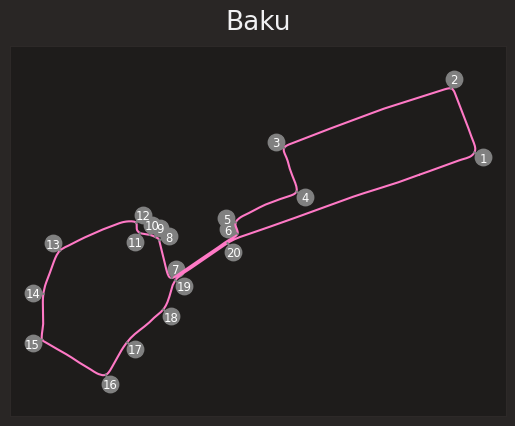

In [74]:
lap = race.laps.pick_fastest()
pos = lap.get_pos_data()
circuit_info = race.get_circuit_info()

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
    
plt.title(race.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()  

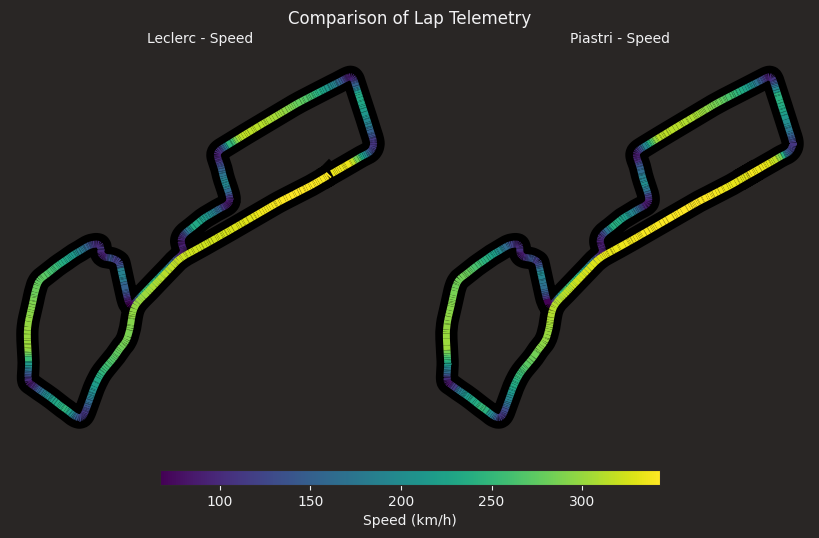

In [30]:
# Função para plotar telemetria de um piloto
def plot_telemetry(ax, lap, driver_name, colormap):
    # Dados de telemetria
    x = lap.telemetry['X']              # valores para o eixo X
    y = lap.telemetry['Y']              # valores para o eixo Y
    color = lap.telemetry['Speed']      # valor para o gradiente de cor

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plotar linha de fundo da pista
    ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)

    # Criar gradiente de cor com base na velocidade
    norm = plt.Normalize(color.min(), color.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm,
                        linestyle='-', linewidth=5)

    # Set the values used for colormapping
    lc.set_array(color)

    # Adicionar ao gráfico
    ax.add_collection(lc)
    ax.set_title(f'{driver_name} - Speed', size=10)
    ax.axis('off')

# Criar figura com dois subplots lado a lado
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle('Comparison of Lap Telemetry', size=12, y=1)

# Ajustar margens e espaçamento entre os gráficos
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.1)

# Plotar telemetria de Leclerc no primeiro gráfico
lap_leclerc = race.laps.pick_driver('LEC').pick_fastest()  # Defina corretamente o piloto
plot_telemetry(axs[0], lap_leclerc, 'Leclerc', 'viridis')

# Plotar telemetria de Verstappen no segundo gráfico
lap_verstappen = race.laps.pick_driver('PIA').pick_fastest()  # Defina corretamente o piloto
plot_telemetry(axs[1], lap_verstappen, 'Piastri', 'viridis')

# Adicionar barra de cores na parte inferior
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.03])
normlegend = mpl.colors.Normalize(vmin=min(lap_leclerc.telemetry['Speed'].min(), lap_verstappen.telemetry['Speed'].min()), 
                                  vmax=max(lap_leclerc.telemetry['Speed'].max(), lap_verstappen.telemetry['Speed'].max()))
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap='viridis', orientation="horizontal")
legend.set_label('Speed (km/h)', size=10)

plt.show()


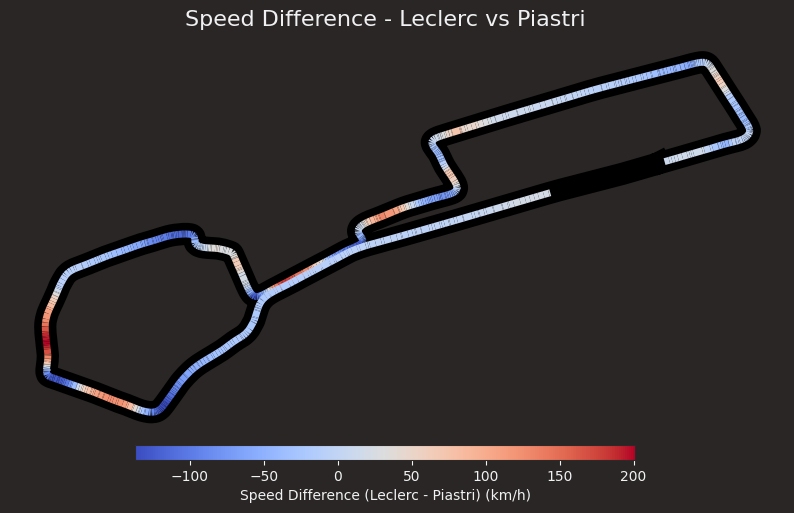

In [31]:
# Função para calcular e plotar a diferença de velocidade entre dois pilotos
def plot_speed_difference(ax, lap1, lap2, driver1_name, driver2_name, colormap):
    # Dados de telemetria de ambos os pilotos
    x = lap1.telemetry['X']  # valores para o eixo X (assumimos que ambos têm os mesmos valores X e Y)
    y = lap1.telemetry['Y']  # valores para o eixo Y
    speed_diff = lap1.telemetry['Speed'] - lap2.telemetry['Speed']  # diferença de velocidade

    # Converter para segmentos para a plotagem
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plotar a linha de fundo da pista
    ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)

    # Criar gradiente de cor com base na diferença de velocidade
    norm = plt.Normalize(speed_diff.min(), speed_diff.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

    # Aplicar a coloração pela diferença de velocidade
    lc.set_array(speed_diff)

    # Adicionar ao gráfico
    ax.add_collection(lc)
    ax.axis('off')

# Criar figura para o heatmap
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Speed Difference - Leclerc vs Piastri', size=16, y=0.95)

# Obter as voltas mais rápidas de Leclerc e Piastri
lap_leclerc = race.laps.pick_driver('LEC').pick_fastest()  # Substitua pelos dados corretos
lap_verstappen = race.laps.pick_driver('PIA').pick_fastest()  # Substitua pelos dados corretos

# Plotar a diferença de velocidade
plot_speed_difference(ax, lap_leclerc, lap_verstappen, 'Leclerc', 'Piastri', 'coolwarm')

# Adicionar barra de cores para a diferença de velocidade
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Posição da barra de cores
normlegend = mpl.colors.Normalize(vmin=(lap_leclerc.telemetry['Speed'] - lap_verstappen.telemetry['Speed']).min(), 
                                  vmax=(lap_leclerc.telemetry['Speed'] - lap_verstappen.telemetry['Speed']).max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap='coolwarm', orientation="horizontal")
legend.set_label('Speed Difference (Leclerc - Piastri) (km/h)', size=10)

plt.show()

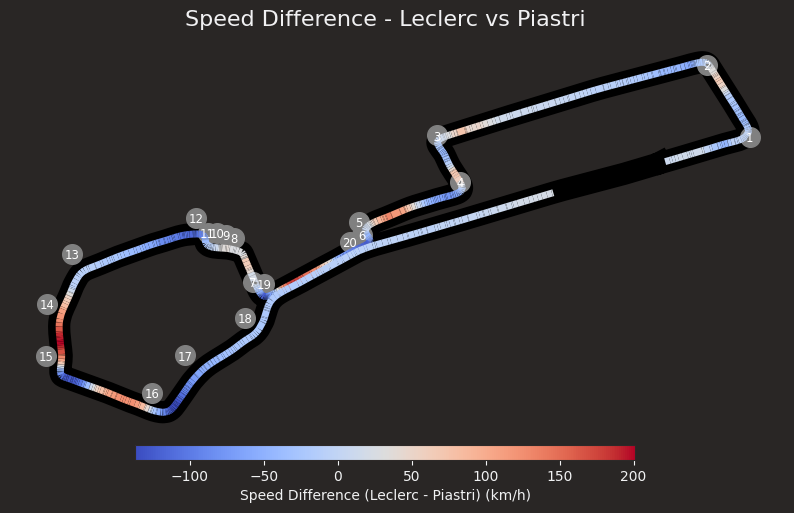

In [83]:
# Função para calcular e plotar a diferença de velocidade entre dois pilotos
def plot_speed_difference(ax, lap1, lap2, driver1_name, driver2_name, colormap, circuit_info):
    # Dados de telemetria de ambos os pilotos
    x = lap1.telemetry['X']  # valores para o eixo X (assumimos que ambos têm os mesmos valores X e Y)
    y = lap1.telemetry['Y']  # valores para o eixo Y
    speed_diff = lap1.telemetry['Speed'] - lap2.telemetry['Speed']  # diferença de velocidade

    # Converter para segmentos para a plotagem
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plotar a linha de fundo da pista
    ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)

    # Criar gradiente de cor com base na diferença de velocidade
    norm = plt.Normalize(speed_diff.min(), speed_diff.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

    # Aplicar a coloração pela diferença de velocidade
    lc.set_array(speed_diff)

    # Adicionar ao gráfico
    ax.add_collection(lc)
    ax.axis('off')

    # Adicionar as curvas ao gráfico
    plot_corners(ax, circuit_info)

# Função para desenhar as curvas no gráfico
def plot_corners(ax, circuit_info):
    def rotate(xy, *, angle):
        rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                            [-np.sin(angle), np.cos(angle)]])
        return np.matmul(xy, rot_mat)

    # Pegar dados da pista e rotacionar com base no ângulo da pista
    track = circuit_info['pos'].loc[:, ('X', 'Y')].to_numpy()
    track_angle = circuit_info['info'].rotation / 180 * np.pi
    rotated_track = rotate(track, angle=track_angle)
    
    # Plotar o mapa da pista rotacionado
    #ax.plot(rotated_track[:, 0], rotated_track[:, 1])

    offset_vector = [0, 100]  # vetor de offset escolhido arbitrariamente para ajustar o visual

    # Iterar sobre todas as curvas
    for _, corner in circuit_info['corners'].iterrows():
        txt = f"{corner['Number']}{corner['Letter']}"
        offset_angle = corner['Angle'] / 180 * np.pi
        offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

        text_x = corner['X'] + offset_x
        text_y = corner['Y'] + offset_y
        text_x, text_y = rotate([text_x, text_y], angle=track_angle)

        track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

        # Desenhar círculo próximo à pista
        ax.scatter(text_x, text_y, color='grey', s=200)
        ax.plot([track_x, text_x], [track_y, text_y], color='grey')

        # Colocar o número da curva no círculo
        ax.text(text_x, text_y, txt, va='center_baseline', ha='center', size='small', color='white')

# Criar figura para o heatmap
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Speed Difference - Leclerc vs Piastri', size=16, y=0.95)

# Obter as voltas mais rápidas de Leclerc e Piastri
lap_leclerc = race.laps.pick_driver('LEC').pick_fastest()  # Substitua pelos dados corretos
lap_piastri = race.laps.pick_driver('PIA').pick_fastest()  # Substitua pelos dados corretos

# Obter informações da pista e curvas
pos = lap_leclerc.get_pos_data()  # Posição da volta
circuit_info = {
    'pos': pos,
    'info': race.get_circuit_info(),
    'corners': race.get_circuit_info().corners
}

# Plotar a diferença de velocidade
plot_speed_difference(ax, lap_leclerc, lap_piastri, 'Leclerc', 'Piastri', 'coolwarm', circuit_info)

# Adicionar barra de cores para a diferença de velocidade
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # Posição da barra de cores
normlegend = mpl.colors.Normalize(vmin=(lap_leclerc.telemetry['Speed'] - lap_piastri.telemetry['Speed']).min(), 
                                  vmax=(lap_leclerc.telemetry['Speed'] - lap_piastri.telemetry['Speed']).max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap='coolwarm', orientation="horizontal")
legend.set_label('Speed Difference (Leclerc - Piastri) (km/h)', size=10)

plt.show()


#### Comparação Piastri e Leclerc

In [100]:
# Filtrar os pilotos da Top
top_drivers = ['PIA', 'LEC']  # P1 e P2, ajuste conforme os pilotos da Top

# Obtém os dados de volta para os pilotos da Top
top_laps = {driver: race.laps.pick_driver(driver) for driver in top_drivers}

# Combinar os dados dos dois pilotos
combined_laps = pd.concat(top_laps.values())

# Adicionar uma coluna para o tempo total em segundos
combined_laps['LapTime (s)'] = combined_laps['LapTime'].dt.total_seconds()

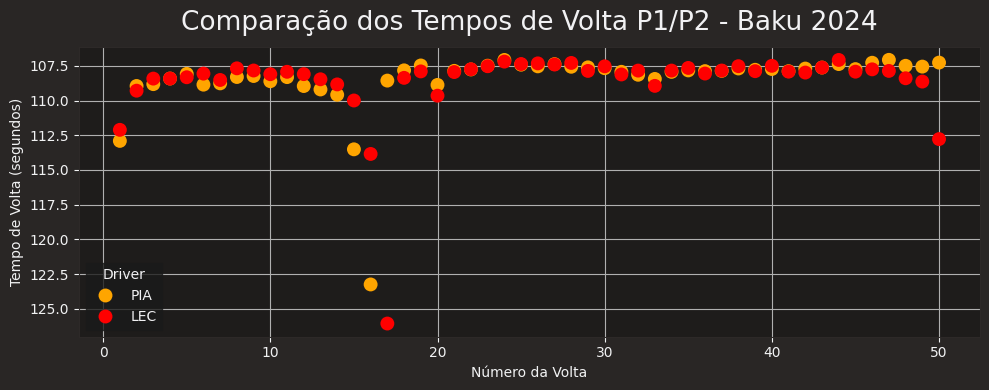

In [101]:
# Criar o gráfico de comparação dos tempos de volta
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=combined_laps,
                x='LapNumber',
                y='LapTime (s)',
                hue='Driver',
                palette={'PIA': 'orange', 'LEC': 'red'},
                ax=ax,
                s=100,
                linewidth=0)
ax.set_xlabel('Número da Volta')
ax.set_ylabel('Tempo de Volta (segundos)')
ax.set_title('Comparação dos Tempos de Volta P1/P2 - Baku 2024')
ax.invert_yaxis()  # Inverte o eixo Y para mostrar tempos mais baixos no topo
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [102]:
# Calcular deltas de tempo entre os dois pilotos
# Primeiro, garantir que 'LapTime' esteja disponível e corretamente nomeada
for driver in top_drivers:
    if 'LapTime' not in top_laps[driver].columns:
        print(f"'LapTime' não encontrado para {driver}")

In [103]:
# Criação de um DataFrame com os tempos das voltas dos dois pilotos
delta_time = pd.merge(
    top_laps['PIA'][['LapNumber', 'LapTime']],
    top_laps['LEC'][['LapNumber', 'LapTime']],
    on='LapNumber',
    suffixes=('_PIA', '_LEC')
)
delta_time['LapTime (s)_PIA'] = delta_time['LapTime_PIA'].dt.total_seconds()
delta_time['LapTime (s)_LEC'] = delta_time['LapTime_LEC'].dt.total_seconds()
delta_time['Delta'] = delta_time['LapTime (s)_PIA'] - delta_time['LapTime (s)_LEC']

In [108]:
delta_time[['LapNumber', 'LapTime (s)_PIA', 'LapTime (s)_LEC', 'Delta']]

,LapNumber,LapTime (s)_PIA,LapTime (s)_LEC,Delta
0,1.0,112.903,112.106,0.797
1,2.0,108.944,109.283,-0.339
2,3.0,108.811,108.412,0.399
3,4.0,108.408,108.408,0.000
4,5.0,108.070,108.314,-0.244
5,6.0,108.848,108.052,0.796
6,7.0,108.755,108.511,0.244
7,8.0,108.297,107.672,0.625
8,9.0,108.225,107.828,0.397
9,10.0,108.601,108.094,0.507


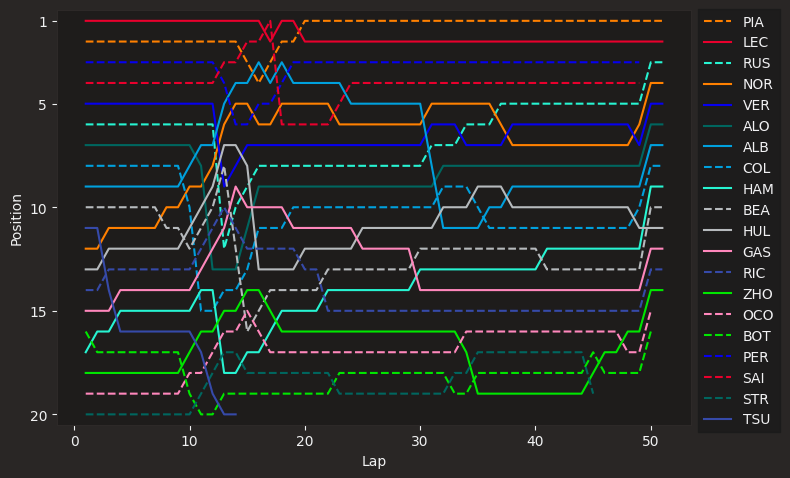

In [110]:
fig, ax = plt.subplots(figsize=(8.0, 4.9))

for drv in race.drivers:
    drv_laps = race.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]
    style = fastf1.plotting.get_driver_style(identifier=abb,
                                             style=['color', 'linestyle'],
                                             session=race)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, **style)
    
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()

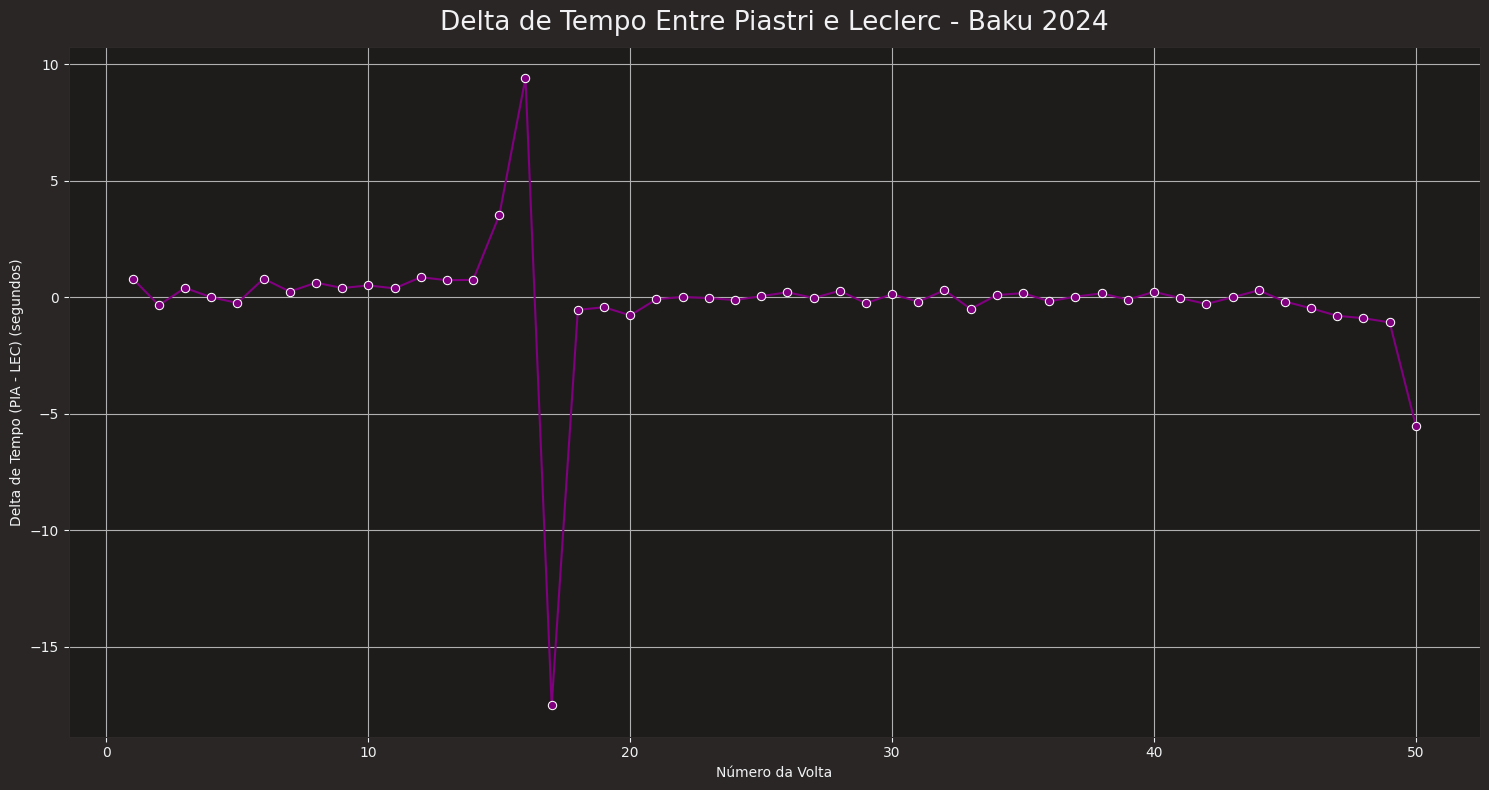

Estatísticas dos Tempos de Volta:
        count       mean       std      min        25%       50%      75%  \
Driver                                                                      
LEC      50.0  108.67784  2.835023  107.067  107.68825  107.9170  108.411   
PIA      50.0  108.49346  2.437127  107.060  107.56875  107.8555  108.526   

            max  
Driver           
LEC     126.071  
PIA     123.253  

Delta de Tempo Médio:
-0.18437999999999988

Delta de Tempo Máximo:
9.409000000000006

Delta de Tempo Mínimo:
-17.515


In [106]:
# Criar o gráfico de delta de tempo
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=delta_time,
             x='LapNumber',
             y='Delta',
             marker='o',
             color='purple',
             ax=ax)

ax.set_xlabel('Número da Volta')
ax.set_ylabel('Delta de Tempo (PIA - LEC) (segundos)')
ax.set_title('Delta de Tempo Entre Piastri e Leclerc - Baku 2024')
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

# Exibir algumas estatísticas interessantes
print("Estatísticas dos Tempos de Volta:")
print(combined_laps.groupby('Driver')['LapTime (s)'].describe())
print("\nDelta de Tempo Médio:")
print(delta_time['Delta'].mean())
print("\nDelta de Tempo Máximo:")
print(delta_time['Delta'].max())
print("\nDelta de Tempo Mínimo:")
print(delta_time['Delta'].min())

In [112]:
from fastf1.ergast import Ergast

SEASON = 2024
ROUND = 17

def get_drivers_standings():
    ergast = Ergast()
    standings = ergast.get_driver_standings(season=SEASON, round=ROUND)
    return standings.content[0]

def calculate_max_points_for_remaining_season():
    POINTS_FOR_SPRINT = 8 + 25 + 1  # Winning the sprint, race and fastest lap
    POINTS_FOR_CONVENTIONAL = 25 + 1  # Winning the race and fastest lap

    events = fastf1.events.get_event_schedule(SEASON, backend='ergast')
    events = events[events['RoundNumber'] > ROUND]
    # Count how many sprints and conventional races are left
    sprint_events = len(events.loc[events["EventFormat"] == "sprint_shootout"])
    conventional_events = len(events.loc[events["EventFormat"] == "conventional"])

    # Calculate points for each
    sprint_points = sprint_events * POINTS_FOR_SPRINT
    conventional_points = conventional_events * POINTS_FOR_CONVENTIONAL

    return sprint_points + conventional_points

def calculate_who_can_win(driver_standings, max_points):
    LEADER_POINTS = int(driver_standings.loc[0]['points'])

    for i, _ in enumerate(driver_standings.iterrows()):
        driver = driver_standings.loc[i]
        driver_max_points = int(driver["points"]) + max_points
        can_win = 'No' if driver_max_points < LEADER_POINTS else 'Yes'

        print(f"{driver['position']}: {driver['givenName'] + ' ' + driver['familyName']}, "
              f"Current points: {driver['points']}, "
              f"Theoretical max points: {driver_max_points}, "
              f"Can win: {can_win}")
        
# Get the current drivers standings
driver_standings = get_drivers_standings()

# Get the maximum amount of points
points = calculate_max_points_for_remaining_season()

# Print which drivers can still win
calculate_who_can_win(driver_standings, points)        

1: Max Verstappen, Current points: 313.0, Theoretical max points: 417, Can win: Yes
2: Lando Norris, Current points: 254.0, Theoretical max points: 358, Can win: Yes
3: Charles Leclerc, Current points: 235.0, Theoretical max points: 339, Can win: Yes
4: Oscar Piastri, Current points: 222.0, Theoretical max points: 326, Can win: Yes
5: Carlos Sainz, Current points: 184.0, Theoretical max points: 288, Can win: No
6: Lewis Hamilton, Current points: 166.0, Theoretical max points: 270, Can win: No
7: George Russell, Current points: 143.0, Theoretical max points: 247, Can win: No
8: Sergio Pérez, Current points: 143.0, Theoretical max points: 247, Can win: No
9: Fernando Alonso, Current points: 58.0, Theoretical max points: 162, Can win: No
10: Lance Stroll, Current points: 24.0, Theoretical max points: 128, Can win: No
11: Nico Hülkenberg, Current points: 22.0, Theoretical max points: 126, Can win: No
12: Yuki Tsunoda, Current points: 22.0, Theoretical max points: 126, Can win: No
13: Alexa